In [1]:
import scipy

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Add, add
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.applications import vgg19
#from tensorflow.python.keras.utils import plot_model
from keras.utils import plot_model
#from tensorflow.python.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import load_img
from PIL import Image
#from tensorflow.python.keras.models import Sequential, Model
from keras.models import Sequential, Model
#from tensorflow.python.keras.optimizers import Adam
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.python.keras.backend as K
from tqdm import tqdm

from tensorflow.python.platform.tf_logging import set_verbosity, FATAL
#отключаем отображение некритических предупреждений
set_verbosity(FATAL)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '0'

In [2]:
img_shape = (256,384,3) #размер изображения
height=img_shape[0]
width=img_shape[1]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q '/content/drive/MyDrive/Нейросети/Human Segmentation Dataset.zip'

In [5]:
def img_to_array(img, data_format='channels_last', dtype='float32'):

    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: %s' % data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=dtype)
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: %s' % (x.shape,))
    return x


In [6]:
from PIL import Image

In [7]:
!pip install Pillow


In [9]:
images = []
for image in sorted(os.listdir('images')): #проходим по каждому файлу, получив список файлов в папке
  print(image)
  images.append(img_to_array(load_img('images/'+image, target_size=(height,width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
images = np.stack(images).astype('uint8') #сохраняем итоговый массив изображений
images = images[:10]

ds1_bow-tie-businessman-fashion-man.png
ds1_bow-tie-fashion-man-person.png
ds1_brown-brunette-female-finger-41551.png
ds1_child-children-girl-happy.png
ds1_city-woman-view-blue-sky.png
ds1_dawn-sunset-person-woman.png
ds1_entrepreneur-startup-start-up-man-39866.png
ds1_family-toddler-hapy-happy-160688.png
ds1_fashionable-girl-in-glasses-in-the-black-pants-157886.png
ds1_girl-dress-bounce-nature-160826.png
ds1_girl-dress-white-ruins-160544.png
ds1_girl-eyes-makeup-sexy-60883.png
ds1_girl-people-landscape-sun-38554.png
ds1_girl-water-flowers-beauty-160673.png
ds1_healthy-person-woman-sport.png
ds1_information-information-board-message-business-card-39604.png
ds1_kid-girl-child-cute-160433.png
ds1_man-crazy-funny-dude-45882.png
ds1_man-person-jumping-desert.png
ds1_man-person-people-emotions.png
ds1_man-relax-couch-study.png
ds1_nature-person-red-woman.png
ds1_people-mother-family-father.png
ds1_person-couple-love-romantic.png
ds1_person-human-male-man.png
ds1_person-young-man-beard-emoti

In [10]:
masks = []
for image in sorted(os.listdir('masks')): #проходим по каждому файлу, получив список файлов в папке
  print(image)
  masks.append(img_to_array(load_img('masks/'+image, target_size=(height,width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
masks = np.stack(masks).astype('uint8') #сохраняем итоговый массив изображений
masks = masks[:10]

ds1_bow-tie-businessman-fashion-man.png
ds1_bow-tie-fashion-man-person.png
ds1_brown-brunette-female-finger-41551.png
ds1_child-children-girl-happy.png
ds1_city-woman-view-blue-sky.png
ds1_dawn-sunset-person-woman.png
ds1_entrepreneur-startup-start-up-man-39866.png
ds1_family-toddler-hapy-happy-160688.png
ds1_fashionable-girl-in-glasses-in-the-black-pants-157886.png
ds1_girl-dress-bounce-nature-160826.png
ds1_girl-dress-white-ruins-160544.png
ds1_girl-eyes-makeup-sexy-60883.png
ds1_girl-people-landscape-sun-38554.png
ds1_girl-water-flowers-beauty-160673.png
ds1_healthy-person-woman-sport.png
ds1_information-information-board-message-business-card-39604.png
ds1_kid-girl-child-cute-160433.png
ds1_man-crazy-funny-dude-45882.png
ds1_man-person-jumping-desert.png
ds1_man-person-people-emotions.png
ds1_man-relax-couch-study.png
ds1_nature-person-red-woman.png
ds1_people-mother-family-father.png
ds1_person-couple-love-romantic.png
ds1_person-human-male-man.png
ds1_person-young-man-beard-emoti

In [11]:
def build_generator():
    gf = 64 #минимальное число фильтров


    def conv2d(layer_input, filters, f_size=4, bn=True): #слой с понижением разрешения (encoder)

        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input) #strides = 2 уменьшает разрешение в 2 раза при padding='same'
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0): #слой с повышением разрешения (decoder) принимает на вход предыдущий слой и skip-слой от encoder'а
        u = UpSampling2D(size=2)(layer_input) #увеличивам разрешение в 2 раза
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u) #strides=1, padding='same',  поэтому разрешение сохраняется
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input]) #соединяем skip-слой и слой decoder'а
        return u


    d0 = Input(shape=img_shape, name="condition") #входное изображение (условие)

    # Часть encoder'a
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4) #чем меньше размер карт активаций
    d4 = conv2d(d3, gf*8) #тем больше должно быть фильтров в сверточном слое
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    # Часть decoder'a
    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8)
    u3 = deconv2d(u2, d4, gf*8) #чем больше размер карт активаций
    u4 = deconv2d(u3, d3, gf*4) #тем меньше должно быть фильтров в сверточном слое
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh', name='G_output')(u7) #интенсивность должна быть от -1 до 1, поэтому используем tanh

    return Model(d0, output_img, name="G")

In [12]:
gen = build_generator() #создаем генератор
gen.summary()

Model: "G"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 condition (InputLayer)      [(None, 256, 384, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 192, 64)         3136      ['condition[0][0]']           
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 192, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 96, 128)          131200    ['leaky_re_lu[0][0]']         
                                                                                                  

In [13]:
def build_discriminator():

  df = 64 #минимальное число фильтров
  def d_layer(layer_input, filters, f_size=4, bn=True): #слой дискриминатора с понижением разрешения

      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input) #размер карт активаций будет уменьшен в 2 раза, так как strides=2 при padding='same'
      d = LeakyReLU(alpha=0.2)(d)
      if bn:
          d = BatchNormalization(momentum=0.8)(d)
      return d

  image = Input(shape=img_shape, name="real_or_fake_A") #на вход дискриминатору подается либо реальное изображение, либо фейковое
  condition = Input(shape=img_shape, name="condition") #и дополнительно изображение-условие

  combined_imgs = Concatenate(axis=-1)([image, condition]) #объединяем оба входа в 1 слой

  d1 = d_layer(combined_imgs, df, bn=False)
  d2 = d_layer(d1, df*2)
  d3 = d_layer(d2, df*4) #уменьшаем размер карт активации, увеличивая их число
  d4 = d_layer(d3, df*8)

  validity = Conv2D(1, kernel_size=4, strides=1, padding='same', name='D_output', activation='sigmoid')(d4) #на выходе будет двумерный массив, каждый элемент которого определяет, подлинность части изображения (patch GAN)
                                                                                                            #0 отвечает за фейковые изображения, 1 за подлинные, поэтому используем sigmoid

  return Model([image, condition], validity, name='D')

In [14]:
dis = build_discriminator()
dis.summary()

Model: "D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 real_or_fake_A (InputLayer  [(None, 256, 384, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 condition (InputLayer)      [(None, 256, 384, 3)]        0         []                            
                                                                                                  
 concatenate_6 (Concatenate  (None, 256, 384, 6)          0         ['real_or_fake_A[0][0]',      
 )                                                                   'condition[0][0]']           
                                                                                                  

In [15]:
def build_vgg():
  #для feature loss создаем vgg модель
  vgg_in = Input(img_shape)
  vgg = vgg19.VGG19(include_top=False, input_shape=img_shape, input_tensor=vgg_in) #скачиваем архитектуру и веса
  vgg_out = vgg.get_layer('block5_conv4').output #получаем последний сверточный слой
  vgg = Model(vgg_in, vgg_out, name='vgg')
  vgg.trainable = False #модель уже предобучена, поэтому ее необходимо заморозить

  return vgg

In [16]:
vgg = build_vgg()
vgg.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 384, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 384, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 384, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 192, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 192, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 192, 128)     147584    
                                                                

# CycleGAN

In [17]:
!pip install keras

In [18]:
import keras

In [19]:
class CycleGan(keras.Model):
    def __init__(self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,lambda_cycle=15):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer

        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        #real_monet y，real_photo x，m_gen G，p_gen F，p_disc DX，m_disc DY

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)#G(x)
            cycled_photo = self.p_gen(fake_monet, training=True)#F(G(x))

            fake_photo = self.p_gen(real_monet, training=True)#F(y)
            cycled_monet = self.m_gen(fake_photo, training=True)#G(F(y))

            same_monet = self.m_gen(real_monet, training=True)#G(y)
            same_photo = self.p_gen(real_photo, training=True)#F(x)

            disc_real_monet = self.m_disc(real_monet, training=True)#DY(y)
            disc_real_photo = self.p_disc(real_photo, training=True)#DX(x)

            disc_fake_monet = self.m_disc(fake_monet, training=True)#DY(G(x))
            disc_fake_photo = self.p_disc(fake_photo, training=True)#DX(F(y))

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)


        monet_generator_gradients = tape.gradient(total_monet_gen_loss,self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))

        '''if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)'''


        return {"monet_gen_loss": total_monet_gen_loss,"photo_gen_loss": total_photo_gen_loss,"monet_disc_loss": monet_disc_loss,"photo_disc_loss": photo_disc_loss}

In [20]:
def build_CycleGan(generator, discriminator, vgg):
  discriminator.trainable = False #замораживаем дискриминатор

  condition = Input(img_shape, name='Condition') #вход изображения-условия
  fake_img = generator(condition) #изображение, полученное от генератора

  fake_features = vgg(fake_img) #карты активации, полученные от фейкового изображения

  fake_validity = discriminator([fake_img, condition]) #соединяем генератор и дискриминатор

  CycleGan = Model(condition, [fake_validity, fake_img, fake_features]) #получаем CycleGan с тремя выходами: первый отвечает за "правдоподобность", второй за изображение от генератора, третий за карты активации

  return CycleGan

In [21]:
dis.output_shape[1:]

(16, 24, 1)

In [22]:
(np.ones((128, *dis.output_shape[1:]))).shape

(128, 16, 24, 1)

In [23]:
def train(generator, discriminator, CycleGan, vgg, images, masks, epochs, batch_size):

  for epoch in range(epochs):
    idx = np.random.choice(images.shape[0], images.shape[0], replace=False) #перемешиваем индексы, чтобы batch'и всегда были разными

    with tqdm(total=images.shape[0]) as pbar: #для отслеживания создаем progressbar
      for batch in range(images.shape[0]//batch_size):

        #для тренировки дискриминатора применяем label smoothing
        #размерность Y: (размер батча, высота последнего слоя дискриминатора, ширина, 1)
        y_real = np.ones((batch_size, *discriminator.output_shape[1:])) - np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2
        y_fake = np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2

        idx_batch = idx[batch*batch_size:(batch+1)*batch_size] #получаем индексы для одного batch'а

        real_imgs = (images[idx_batch]/127.5)-1 #получаем истинные изображения и нормализуем их
        condition = (masks[idx_batch]/127.5)-1 #получаем маски и нормализуем их

        fake_imgs = generator.predict(condition) #генерируем изображения по маскам

        #тренируем дискриминатор
        d_loss_real = discriminator.train_on_batch([real_imgs, condition], y_real)
        d_loss_fake = discriminator.train_on_batch([fake_imgs, condition], y_fake)
        d_loss_total = 0.5*np.add(d_loss_real, d_loss_fake)

        #тренируем генератор
        real_features = vgg.predict(real_imgs)
        y_real = np.ones((batch_size, *discriminator.output_shape[1:]))

        g_loss = CycleGan.train_on_batch(condition, [y_real, real_imgs, real_features])
        pbar.update(batch_size) #обновляем progressbar
        pbar.set_description("Epoch: {}/{}, Discriminator loss: {}, Generator loss:{}".format(epoch+1, epochs, d_loss_total[0], g_loss))

In [24]:
gen = build_generator() #создаем генератор

dis = build_discriminator() #создаем дискриминатор
dis.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4, beta_1=0.5), metrics=['accuracy'])

vgg = build_vgg() #создаем vgg модель

CycleGan = build_CycleGan(gen, dis, vgg) #создаем CycleGan
CycleGan.compile(loss=['binary_crossentropy', 'mse', 'mse'], loss_weights=[1,100,10], optimizer=Adam(learning_rate=1e-4, beta_1=0.5)) #вклад разницы между пикселями в 10 раз больше, чем вклад от feature loss и в 100 раз больше, чем вклад от GAN

In [25]:
gen.summary()

Model: "G"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 condition (InputLayer)      [(None, 256, 384, 3)]        0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 128, 192, 64)         3136      ['condition[0][0]']           
                                                                                                  
 leaky_re_lu_11 (LeakyReLU)  (None, 128, 192, 64)         0         ['conv2d_17[0][0]']           
                                                                                                  
 conv2d_18 (Conv2D)          (None, 64, 96, 128)          131200    ['leaky_re_lu_11[0][0]']      
                                                                                                  

In [26]:
dis.summary()

Model: "D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 real_or_fake_A (InputLayer  [(None, 256, 384, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 condition (InputLayer)      [(None, 256, 384, 3)]        0         []                            
                                                                                                  
 concatenate_13 (Concatenat  (None, 256, 384, 6)          0         ['real_or_fake_A[0][0]',      
 e)                                                                  'condition[0][0]']           
                                                                                                  

In [27]:
vgg.summary()

Model: "vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 384, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 384, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 384, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 192, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 192, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 192, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 96, 128)       0       

In [28]:
train(gen, dis, CycleGan, vgg, images, masks, 195, 8)

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 1/195, Discriminator loss: 1.7578121721744537, Generator loss:[78.11506652832031, 0.7345809936523438, 0.7638540863990784, 0.09950793534517288]:  80%|████████  | 8/10 [02:17<00:34, 17.18s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 2/195, Discriminator loss: 1.3162447214126587, Generator loss:[67.86946105957031, 0.8126097321510315, 0.6615180969238281, 0.09050455689430237]:  80%|████████  | 8/10 [01:57<00:29, 14.68s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 3/195, Discriminator loss: 1.1500591337680817, Generator loss:[44.04496383666992, 0.8474931120872498, 0.42330002784729004, 0.08674683421850204]:  80%|████████  | 8/10 [02:51<00:42, 21.46s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 4/195, Discriminator loss: 0.7664055824279785, Generator loss:[34.76854705810547, 0.9434762597084045, 0.3298330008983612, 0.08417689055204391]:  80%|████████  | 8/10 [02:09<00:32, 16.16s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 5/195, Discriminator loss: 0.7597924172878265, Generator loss:[25.50819969177246, 0.8984601497650146, 0.23810891807079315, 0.07988478988409042]:  80%|████████  | 8/10 [01:49<00:27, 13.74s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 6/195, Discriminator loss: 0.7003474533557892, Generator loss:[19.928577423095703, 0.9056122899055481, 0.1823250651359558, 0.07904595881700516]:  80%|████████  | 8/10 [01:49<00:27, 13.68s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 7/195, Discriminator loss: 0.6765662431716919, Generator loss:[20.66830062866211, 0.9300789833068848, 0.18993401527404785, 0.07448223978281021]:  80%|████████  | 8/10 [02:02<00:30, 15.27s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 8/195, Discriminator loss: 0.6914691627025604, Generator loss:[18.94109535217285, 0.9491963982582092, 0.17247025668621063, 0.07448726892471313]:  80%|████████  | 8/10 [02:04<00:31, 15.61s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 9/195, Discriminator loss: 0.6568306088447571, Generator loss:[18.123031616210938, 0.904451310634613, 0.16498470306396484, 0.07201090455055237]:  80%|████████  | 8/10 [02:04<00:31, 15.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 10/195, Discriminator loss: 0.6492400169372559, Generator loss:[14.24533462524414, 0.8584721684455872, 0.12660329043865204, 0.0726533904671669]:  80%|████████  | 8/10 [02:11<00:32, 16.42s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 11/195, Discriminator loss: 0.6309561431407928, Generator loss:[15.174775123596191, 0.9079377055168152, 0.1350335031747818, 0.0763486698269844]:  80%|████████  | 8/10 [01:52<00:28, 14.00s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 12/195, Discriminator loss: 0.6374437510967255, Generator loss:[12.257250785827637, 0.8068897128105164, 0.10784286260604858, 0.06660745292901993]:  80%|████████  | 8/10 [02:02<00:30, 15.26s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 13/195, Discriminator loss: 0.6126924753189087, Generator loss:[10.702393531799316, 0.8080387711524963, 0.09236699342727661, 0.06576558202505112]:  80%|████████  | 8/10 [02:03<00:30, 15.45s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 14/195, Discriminator loss: 0.5977556705474854, Generator loss:[10.75393009185791, 0.82688969373703, 0.09246780723333359, 0.06802599877119064]:  80%|████████  | 8/10 [02:02<00:30, 15.36s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 15/195, Discriminator loss: 0.6023672223091125, Generator loss:[11.512042045593262, 0.8290216326713562, 0.10006510466337204, 0.06765101104974747]:  80%|████████  | 8/10 [02:10<00:32, 16.36s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 16/195, Discriminator loss: 0.6143162548542023, Generator loss:[10.857745170593262, 0.9897636771202087, 0.09207183122634888, 0.06607986241579056]:  80%|████████  | 8/10 [01:53<00:28, 14.20s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 17/195, Discriminator loss: 0.6638484299182892, Generator loss:[9.706774711608887, 0.8263140320777893, 0.08247867226600647, 0.06325928121805191]:  80%|████████  | 8/10 [02:02<00:30, 15.30s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 18/195, Discriminator loss: 0.6560745239257812, Generator loss:[9.732316970825195, 0.8607723116874695, 0.08244252949953079, 0.06272918730974197]:  80%|████████  | 8/10 [02:02<00:30, 15.27s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 19/195, Discriminator loss: 0.6525002717971802, Generator loss:[8.79096508026123, 0.8695192337036133, 0.07287568598985672, 0.06338775157928467]:  80%|████████  | 8/10 [01:57<00:29, 14.72s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 20/195, Discriminator loss: 0.6207811236381531, Generator loss:[9.96198558807373, 0.7356888651847839, 0.08600565791130066, 0.06257302314043045]:  80%|████████  | 8/10 [01:51<00:27, 13.91s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 21/195, Discriminator loss: 0.6177526116371155, Generator loss:[9.406485557556152, 0.7140750288963318, 0.08068937063217163, 0.06234732270240784]:  80%|████████  | 8/10 [02:02<00:30, 15.37s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 22/195, Discriminator loss: 0.616445779800415, Generator loss:[8.516868591308594, 0.770193874835968, 0.07150312513113022, 0.05963622406125069]:  80%|████████  | 8/10 [02:04<00:31, 15.53s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 23/195, Discriminator loss: 0.6385383903980255, Generator loss:[8.014904022216797, 0.7487160563468933, 0.06650274246931076, 0.061591316014528275]:  80%|████████  | 8/10 [01:59<00:29, 14.95s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 24/195, Discriminator loss: 0.6280205249786377, Generator loss:[7.516712665557861, 0.7072148323059082, 0.06211767718195915, 0.059773001819849014]:  80%|████████  | 8/10 [02:02<00:30, 15.37s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 25/195, Discriminator loss: 0.6521929800510406, Generator loss:[8.579864501953125, 0.7308885455131531, 0.07245958596467972, 0.06030172109603882]:  80%|████████  | 8/10 [01:50<00:27, 13.83s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 26/195, Discriminator loss: 0.6880632042884827, Generator loss:[10.724760055541992, 0.80594402551651, 0.09335235506296158, 0.05835801362991333]:  80%|████████  | 8/10 [02:08<00:32, 16.01s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 27/195, Discriminator loss: 0.6688185632228851, Generator loss:[10.576005935668945, 0.7661283612251282, 0.09182718396186829, 0.06271588802337646]:  80%|████████  | 8/10 [01:51<00:27, 13.89s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 28/195, Discriminator loss: 0.6917709410190582, Generator loss:[10.472502708435059, 0.698390007019043, 0.09167101234197617, 0.060701195150613785]:  80%|████████  | 8/10 [02:04<00:31, 15.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 29/195, Discriminator loss: 0.6897245049476624, Generator loss:[9.580342292785645, 0.8541987538337708, 0.0815463438630104, 0.057150911539793015]:  80%|████████  | 8/10 [02:11<00:32, 16.39s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 30/195, Discriminator loss: 0.7256999909877777, Generator loss:[9.28792953491211, 0.7238243222236633, 0.07937543839216232, 0.06265614926815033]:  80%|████████  | 8/10 [01:51<00:27, 13.95s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 31/195, Discriminator loss: 0.6957254707813263, Generator loss:[8.405139923095703, 0.7410258650779724, 0.07103788107633591, 0.05603267624974251]:  80%|████████  | 8/10 [02:00<00:30, 15.00s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 32/195, Discriminator loss: 0.7037824392318726, Generator loss:[7.7370758056640625, 0.7071945071220398, 0.06459034234285355, 0.05708469823002815]:  80%|████████  | 8/10 [02:01<00:30, 15.16s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 33/195, Discriminator loss: 0.7178134024143219, Generator loss:[8.539823532104492, 0.7484116554260254, 0.07161892205476761, 0.0629519522190094]:  80%|████████  | 8/10 [01:59<00:29, 14.91s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 34/195, Discriminator loss: 0.7076561450958252, Generator loss:[7.329395771026611, 0.7220368385314941, 0.06028936430811882, 0.05784223601222038]:  80%|████████  | 8/10 [01:58<00:29, 14.85s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 35/195, Discriminator loss: 0.697588175535202, Generator loss:[6.56941032409668, 0.7067224383354187, 0.052897293120622635, 0.05729590728878975]:  80%|████████  | 8/10 [01:48<00:27, 13.59s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 36/195, Discriminator loss: 0.7050877511501312, Generator loss:[6.715230464935303, 0.7075284123420715, 0.054008711129426956, 0.06068306043744087]:  80%|████████  | 8/10 [01:58<00:29, 14.82s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 37/195, Discriminator loss: 0.7057164013385773, Generator loss:[6.2254638671875, 0.7088789939880371, 0.049395203590393066, 0.05770647153258324]:  80%|████████  | 8/10 [02:01<00:30, 15.20s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 38/195, Discriminator loss: 0.7040014863014221, Generator loss:[6.858732223510742, 0.71185702085495, 0.05586013197898865, 0.05608619749546051]:  80%|████████  | 8/10 [02:00<00:30, 15.01s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 39/195, Discriminator loss: 0.7047929763793945, Generator loss:[7.641365051269531, 0.7096379399299622, 0.06377602368593216, 0.05541243031620979]:  80%|████████  | 8/10 [01:59<00:29, 14.99s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 40/195, Discriminator loss: 0.7007733881473541, Generator loss:[6.9210124015808105, 0.7623648643493652, 0.05626533553004265, 0.05321139097213745]:  80%|████████  | 8/10 [01:48<00:27, 13.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 41/195, Discriminator loss: 0.7105534076690674, Generator loss:[10.118962287902832, 0.7473514676094055, 0.08796914666891098, 0.05746955797076225]:  80%|████████  | 8/10 [01:57<00:29, 14.70s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 42/195, Discriminator loss: 0.6923789083957672, Generator loss:[6.824245929718018, 0.729842483997345, 0.05540761724114418, 0.05536414310336113]:  80%|████████  | 8/10 [01:53<00:28, 14.18s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 43/195, Discriminator loss: 0.6986750066280365, Generator loss:[7.968247413635254, 0.696068525314331, 0.06728512793779373, 0.054366592317819595]:  80%|████████  | 8/10 [02:00<00:30, 15.06s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 44/195, Discriminator loss: 0.6999989151954651, Generator loss:[6.602901458740234, 0.7153932452201843, 0.05339887738227844, 0.05476205423474312]:  80%|████████  | 8/10 [02:01<00:30, 15.15s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 45/195, Discriminator loss: 0.709721565246582, Generator loss:[6.208629131317139, 0.7601437568664551, 0.04941412806510925, 0.05070723220705986]:  80%|████████  | 8/10 [01:57<00:29, 14.66s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 46/195, Discriminator loss: 0.6941754817962646, Generator loss:[5.225864410400391, 0.7344722151756287, 0.04023144394159317, 0.046824801713228226]:  80%|████████  | 8/10 [01:50<00:27, 13.87s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 47/195, Discriminator loss: 0.6892786026000977, Generator loss:[5.904803276062012, 0.7274622321128845, 0.04673789069056511, 0.0503552109003067]:  80%|████████  | 8/10 [01:51<00:27, 13.96s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 48/195, Discriminator loss: 0.6845976114273071, Generator loss:[6.6223225593566895, 0.697719395160675, 0.0539618544280529, 0.05284176394343376]:  80%|████████  | 8/10 [02:00<00:30, 15.09s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 49/195, Discriminator loss: 0.6967839896678925, Generator loss:[5.453208923339844, 0.7148444652557373, 0.042697761207818985, 0.0468587763607502]:  80%|████████  | 8/10 [02:12<00:33, 16.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 50/195, Discriminator loss: 0.6944767236709595, Generator loss:[5.718597888946533, 0.7549107670783997, 0.04459480568766594, 0.050420600920915604]:  80%|████████  | 8/10 [01:57<00:29, 14.72s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 51/195, Discriminator loss: 0.6868244409561157, Generator loss:[7.035804271697998, 0.7303994297981262, 0.0579054020345211, 0.05148641765117645]:  80%|████████  | 8/10 [01:50<00:27, 13.80s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 52/195, Discriminator loss: 0.691535234451294, Generator loss:[6.286551475524902, 0.7483474612236023, 0.05024644359946251, 0.0513559989631176]:  80%|████████  | 8/10 [01:57<00:29, 14.63s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 53/195, Discriminator loss: 0.6925776600837708, Generator loss:[7.542261600494385, 0.7735721468925476, 0.062332767993211746, 0.05354127287864685]:  80%|████████  | 8/10 [01:48<00:27, 13.50s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 54/195, Discriminator loss: 0.68232262134552, Generator loss:[5.812954425811768, 0.7117576599121094, 0.04588533565402031, 0.05126634240150452]:  80%|████████  | 8/10 [01:55<00:28, 14.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 55/195, Discriminator loss: 0.6856703758239746, Generator loss:[5.329085350036621, 0.7306175827980042, 0.04092438146471977, 0.05060293897986412]:  80%|████████  | 8/10 [01:52<00:28, 14.08s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 56/195, Discriminator loss: 0.6794497966766357, Generator loss:[5.447707176208496, 0.7245609164237976, 0.04227935150265694, 0.049521107226610184]:  80%|████████  | 8/10 [02:02<00:30, 15.27s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 57/195, Discriminator loss: 0.6911386847496033, Generator loss:[5.450613021850586, 0.7457203269004822, 0.04222976043820381, 0.04819164797663689]:  80%|████████  | 8/10 [02:03<00:30, 15.40s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 58/195, Discriminator loss: 0.6952447891235352, Generator loss:[6.457423210144043, 0.7581861615180969, 0.05181435868144035, 0.05178007110953331]:  80%|████████  | 8/10 [02:00<00:30, 15.11s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 59/195, Discriminator loss: 0.6885971426963806, Generator loss:[5.947356224060059, 0.7426235675811768, 0.04691465198993683, 0.05132673308253288]:  80%|████████  | 8/10 [02:04<00:31, 15.50s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 60/195, Discriminator loss: 0.6765592396259308, Generator loss:[5.413219928741455, 0.7229580283164978, 0.04214046522974968, 0.04762151464819908]:  80%|████████  | 8/10 [02:01<00:30, 15.24s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 61/195, Discriminator loss: 0.6968256533145905, Generator loss:[4.821983337402344, 0.7733322978019714, 0.03595806285738945, 0.045284491032361984]:  80%|████████  | 8/10 [02:05<00:31, 15.72s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 62/195, Discriminator loss: 0.6997056603431702, Generator loss:[5.45913553237915, 0.7655910849571228, 0.042079877108335495, 0.048555683344602585]:  80%|████████  | 8/10 [01:54<00:28, 14.26s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 63/195, Discriminator loss: 0.686314582824707, Generator loss:[4.993045330047607, 0.7216256260871887, 0.037863317877054214, 0.04850875213742256]:  80%|████████  | 8/10 [01:47<00:26, 13.50s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 64/195, Discriminator loss: 0.6852250397205353, Generator loss:[4.874977111816406, 0.692537784576416, 0.03730448707938194, 0.04519907012581825]:  80%|████████  | 8/10 [01:47<00:26, 13.46s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 65/195, Discriminator loss: 0.6838140487670898, Generator loss:[5.464343547821045, 0.7108833193778992, 0.04303925111889839, 0.04495355486869812]:  80%|████████  | 8/10 [01:47<00:26, 13.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 66/195, Discriminator loss: 0.6757191121578217, Generator loss:[5.289483070373535, 0.7366865277290344, 0.04097973182797432, 0.04548230394721031]:  80%|████████  | 8/10 [01:45<00:26, 13.19s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 19s 19s/step


Epoch: 67/195, Discriminator loss: 0.6795060634613037, Generator loss:[6.924102783203125, 0.7394697070121765, 0.05655794218182564, 0.05288393795490265]:  80%|████████  | 8/10 [01:55<00:28, 14.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 68/195, Discriminator loss: 0.692621260881424, Generator loss:[5.539915084838867, 0.7450248599052429, 0.04347188398241997, 0.04477021098136902]:  80%|████████  | 8/10 [01:44<00:26, 13.02s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 69/195, Discriminator loss: 0.685297280550003, Generator loss:[6.2285284996032715, 0.7565631866455078, 0.05021541193127632, 0.04504243656992912]:  80%|████████  | 8/10 [01:41<00:25, 12.73s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 70/195, Discriminator loss: 0.6803537309169769, Generator loss:[5.475251197814941, 0.7068553566932678, 0.04319777712225914, 0.04486185312271118]:  80%|████████  | 8/10 [01:42<00:25, 12.80s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 71/195, Discriminator loss: 0.6766689121723175, Generator loss:[5.832491874694824, 0.725064218044281, 0.045979976654052734, 0.05094297230243683]:  80%|████████  | 8/10 [01:41<00:25, 12.74s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 72/195, Discriminator loss: 0.6834342777729034, Generator loss:[4.945685386657715, 0.7197712063789368, 0.037880558520555496, 0.04378582909703255]:  80%|████████  | 8/10 [01:48<00:27, 13.56s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 73/195, Discriminator loss: 0.6869775652885437, Generator loss:[5.242770671844482, 0.7298965454101562, 0.04051882401108742, 0.046099185943603516]:  80%|████████  | 8/10 [01:46<00:26, 13.36s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 74/195, Discriminator loss: 0.6887995302677155, Generator loss:[5.8752031326293945, 0.722348690032959, 0.046806782484054565, 0.04721761867403984]:  80%|████████  | 8/10 [01:59<00:29, 14.88s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 75/195, Discriminator loss: 0.6762330234050751, Generator loss:[6.864597320556641, 0.7169598937034607, 0.05668950080871582, 0.04786871001124382]:  80%|████████  | 8/10 [01:48<00:27, 13.59s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 76/195, Discriminator loss: 0.6725152134895325, Generator loss:[6.730828285217285, 0.7302618026733398, 0.05535531044006348, 0.046503547579050064]:  80%|████████  | 8/10 [01:52<00:28, 14.09s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 77/195, Discriminator loss: 0.6751347482204437, Generator loss:[5.324191093444824, 0.7537309527397156, 0.04107242450118065, 0.04632179066538811]:  80%|████████  | 8/10 [01:40<00:25, 12.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 78/195, Discriminator loss: 0.6844033300876617, Generator loss:[6.13627815246582, 0.7718908786773682, 0.04899777099490166, 0.0464610755443573]:  80%|████████  | 8/10 [01:40<00:25, 12.62s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 79/195, Discriminator loss: 0.6828777194023132, Generator loss:[5.839000701904297, 0.7506765723228455, 0.04654993489384651, 0.043333034962415695]:  80%|████████  | 8/10 [01:54<00:28, 14.30s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 80/195, Discriminator loss: 0.672508180141449, Generator loss:[5.885802268981934, 0.729106605052948, 0.0468357689678669, 0.04731188341975212]:  80%|████████  | 8/10 [01:41<00:25, 12.73s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 81/195, Discriminator loss: 0.6956866383552551, Generator loss:[5.987493515014648, 0.7564720511436462, 0.04762806370854378, 0.04682151973247528]:  80%|████████  | 8/10 [01:43<00:25, 12.93s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 82/195, Discriminator loss: 0.7035960853099823, Generator loss:[5.599728584289551, 0.7327864170074463, 0.04384682700037956, 0.04822590947151184]:  80%|████████  | 8/10 [01:44<00:26, 13.00s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 83/195, Discriminator loss: 0.6790545582771301, Generator loss:[5.161214351654053, 0.7657696604728699, 0.03903636708855629, 0.049180805683135986]:  80%|████████  | 8/10 [01:44<00:26, 13.01s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 84/195, Discriminator loss: 0.710740476846695, Generator loss:[4.7162346839904785, 0.7783225178718567, 0.03513152524828911, 0.04247593879699707]:  80%|████████  | 8/10 [01:44<00:26, 13.01s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 85/195, Discriminator loss: 0.6837509870529175, Generator loss:[4.391335964202881, 0.706142008304596, 0.032703518867492676, 0.04148419201374054]:  80%|████████  | 8/10 [01:39<00:24, 12.38s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 86/195, Discriminator loss: 0.6719722151756287, Generator loss:[4.320334434509277, 0.7216975092887878, 0.031807396560907364, 0.04178972914814949]:  80%|████████  | 8/10 [02:02<00:30, 15.31s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 87/195, Discriminator loss: 0.6717377603054047, Generator loss:[4.595008850097656, 0.7436688542366028, 0.034120503813028336, 0.04392896592617035]:  80%|████████  | 8/10 [01:56<00:29, 14.54s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 88/195, Discriminator loss: 0.6685975193977356, Generator loss:[4.531070232391357, 0.7623605132102966, 0.033146873116493225, 0.04540225863456726]:  80%|████████  | 8/10 [01:38<00:24, 12.33s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 89/195, Discriminator loss: 0.6781111657619476, Generator loss:[4.220123291015625, 0.7195477485656738, 0.03135133162140846, 0.03654425963759422]:  80%|████████  | 8/10 [01:52<00:28, 14.08s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 90/195, Discriminator loss: 0.6733607053756714, Generator loss:[4.830889701843262, 0.7341902852058411, 0.03661345690488815, 0.04353533685207367]:  80%|████████  | 8/10 [01:42<00:25, 12.81s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 91/195, Discriminator loss: 0.6650059521198273, Generator loss:[4.202117919921875, 0.73992919921875, 0.03065635822713375, 0.03965526446700096]:  80%|████████  | 8/10 [01:55<00:28, 14.39s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 92/195, Discriminator loss: 0.6685081124305725, Generator loss:[5.092417240142822, 0.7478505969047546, 0.038840100169181824, 0.046055663377046585]:  80%|████████  | 8/10 [01:41<00:25, 12.66s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 93/195, Discriminator loss: 0.6676293909549713, Generator loss:[5.194715976715088, 0.7649140357971191, 0.040061257779598236, 0.04236761853098869]:  80%|████████  | 8/10 [01:59<00:29, 14.96s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 94/195, Discriminator loss: 0.6766024529933929, Generator loss:[4.919407844543457, 0.7410998344421387, 0.03743191435933113, 0.04351164028048515]:  80%|████████  | 8/10 [02:00<00:30, 15.04s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 95/195, Discriminator loss: 0.6705391108989716, Generator loss:[4.691955089569092, 0.7359169125556946, 0.03532831370830536, 0.04232067987322807]:  80%|████████  | 8/10 [01:59<00:29, 14.99s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 96/195, Discriminator loss: 0.6776179671287537, Generator loss:[4.191729545593262, 0.7234886288642883, 0.031073546037077904, 0.036088619381189346]:  80%|████████  | 8/10 [02:02<00:30, 15.26s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 97/195, Discriminator loss: 0.6824733912944794, Generator loss:[4.355954647064209, 0.7604255080223083, 0.03206191956996918, 0.03893372043967247]:  80%|████████  | 8/10 [01:59<00:29, 14.88s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 98/195, Discriminator loss: 0.6810823082923889, Generator loss:[6.271180629730225, 0.7789379954338074, 0.050857383757829666, 0.04065048322081566]:  80%|████████  | 8/10 [02:00<00:30, 15.04s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 99/195, Discriminator loss: 0.6755200028419495, Generator loss:[4.819772720336914, 0.7443544268608093, 0.03673731908202171, 0.040168654173612595]:  80%|████████  | 8/10 [01:42<00:25, 12.80s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 100/195, Discriminator loss: 0.6644545495510101, Generator loss:[5.136344909667969, 0.749701976776123, 0.039343178272247314, 0.04523247107863426]:  80%|████████  | 8/10 [01:42<00:25, 12.76s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 101/195, Discriminator loss: 0.6718915700912476, Generator loss:[4.54817533493042, 0.7743399143218994, 0.03362834081053734, 0.04110017418861389]:  80%|████████  | 8/10 [01:50<00:27, 13.87s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 102/195, Discriminator loss: 0.6987806260585785, Generator loss:[3.984623670578003, 0.7634841799736023, 0.028582291677594185, 0.03629101812839508]:  80%|████████  | 8/10 [01:52<00:28, 14.09s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 103/195, Discriminator loss: 0.6863822937011719, Generator loss:[4.96916389465332, 0.7271541953086853, 0.03879160061478615, 0.036284949630498886]:  80%|████████  | 8/10 [01:42<00:25, 12.76s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 104/195, Discriminator loss: 0.6628077328205109, Generator loss:[4.26481294631958, 0.7281548976898193, 0.031570419669151306, 0.03796161338686943]:  80%|████████  | 8/10 [01:41<00:25, 12.71s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 105/195, Discriminator loss: 0.6729708611965179, Generator loss:[4.875306129455566, 0.7688441276550293, 0.03693341836333275, 0.04131205007433891]:  80%|████████  | 8/10 [01:51<00:27, 13.95s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 106/195, Discriminator loss: 0.6887245178222656, Generator loss:[5.376980781555176, 0.8172612190246582, 0.041526518762111664, 0.04070677235722542]:  80%|████████  | 8/10 [01:50<00:27, 13.82s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 107/195, Discriminator loss: 0.6841355562210083, Generator loss:[4.359797954559326, 0.7510868906974792, 0.03228243067860603, 0.038046810775995255]:  80%|████████  | 8/10 [01:52<00:28, 14.08s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 108/195, Discriminator loss: 0.669855922460556, Generator loss:[4.156536102294922, 0.747855007648468, 0.03023345023393631, 0.03853362053632736]:  80%|████████  | 8/10 [01:39<00:24, 12.46s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 109/195, Discriminator loss: 0.6756780743598938, Generator loss:[4.832466125488281, 0.7030946612358093, 0.037427425384521484, 0.03866293281316757]:  80%|████████  | 8/10 [01:41<00:25, 12.64s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 110/195, Discriminator loss: 0.6822354793548584, Generator loss:[4.16050910949707, 0.7355735898017883, 0.03060605563223362, 0.036433011293411255]:  80%|████████  | 8/10 [02:00<00:30, 15.11s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 111/195, Discriminator loss: 0.6742095947265625, Generator loss:[4.453691005706787, 0.7564630508422852, 0.03323161602020264, 0.03740663826465607]:  80%|████████  | 8/10 [01:52<00:28, 14.05s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 112/195, Discriminator loss: 0.6736244261264801, Generator loss:[5.004820823669434, 0.7601016163825989, 0.038529172539711, 0.03918018937110901]:  80%|████████  | 8/10 [01:49<00:27, 13.72s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 113/195, Discriminator loss: 0.6625057756900787, Generator loss:[4.289458751678467, 0.7453603744506836, 0.031767603009939194, 0.036733802407979965]:  80%|████████  | 8/10 [01:52<00:28, 14.06s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 114/195, Discriminator loss: 0.6705596148967743, Generator loss:[5.207625865936279, 0.7870299220085144, 0.04037385806441307, 0.03832102194428444]:  80%|████████  | 8/10 [01:40<00:25, 12.60s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 115/195, Discriminator loss: 0.6866480112075806, Generator loss:[3.807936191558838, 0.7456757426261902, 0.027221212163567543, 0.03401392698287964]:  80%|████████  | 8/10 [01:40<00:25, 12.60s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 116/195, Discriminator loss: 0.6688923835754395, Generator loss:[4.1051530838012695, 0.7296984791755676, 0.03033614158630371, 0.034184038639068604]:  80%|████████  | 8/10 [01:52<00:28, 14.12s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 117/195, Discriminator loss: 0.6800699234008789, Generator loss:[3.617670774459839, 0.7456585764884949, 0.02562987618148327, 0.030902458354830742]:  80%|████████  | 8/10 [01:38<00:24, 12.35s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 118/195, Discriminator loss: 0.6863352954387665, Generator loss:[3.516160249710083, 0.7291682362556458, 0.024822982028126717, 0.030469393357634544]:  80%|████████  | 8/10 [01:59<00:29, 14.93s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 119/195, Discriminator loss: 0.6839712262153625, Generator loss:[3.8137662410736084, 0.7198378443717957, 0.02772446535527706, 0.03214816376566887]:  80%|████████  | 8/10 [01:52<00:28, 14.01s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 120/195, Discriminator loss: 0.6635133326053619, Generator loss:[4.020376682281494, 0.75323885679245, 0.02942204661667347, 0.032493285834789276]:  80%|████████  | 8/10 [01:42<00:25, 12.85s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 121/195, Discriminator loss: 0.6688574552536011, Generator loss:[4.188055992126465, 0.8041191697120667, 0.030156118795275688, 0.036832477897405624]:  80%|████████  | 8/10 [01:49<00:27, 13.67s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 122/195, Discriminator loss: 0.6778396666049957, Generator loss:[3.7162818908691406, 0.7361621856689453, 0.026835838332772255, 0.029653606936335564]:  80%|████████  | 8/10 [01:49<00:27, 13.70s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 123/195, Discriminator loss: 0.6631856858730316, Generator loss:[4.871004581451416, 0.7504644989967346, 0.03728742524981499, 0.03917976841330528]:  80%|████████  | 8/10 [02:00<00:30, 15.00s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 124/195, Discriminator loss: 0.6694075763225555, Generator loss:[4.311391353607178, 0.7443540692329407, 0.03241841867566109, 0.032519567757844925]:  80%|████████  | 8/10 [02:00<00:30, 15.05s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 125/195, Discriminator loss: 0.6763092875480652, Generator loss:[4.057042598724365, 0.6993514895439148, 0.030113041400909424, 0.03463869169354439]:  80%|████████  | 8/10 [01:52<00:28, 14.04s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 126/195, Discriminator loss: 0.665480226278305, Generator loss:[4.609910011291504, 0.7751517295837402, 0.03452102467417717, 0.03826562687754631]:  80%|████████  | 8/10 [01:43<00:25, 12.92s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 127/195, Discriminator loss: 0.6780065298080444, Generator loss:[4.238236904144287, 0.7645764350891113, 0.031139656901359558, 0.03596945106983185]:  80%|████████  | 8/10 [01:43<00:25, 12.92s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 128/195, Discriminator loss: 0.6716686487197876, Generator loss:[5.519897937774658, 0.7278353571891785, 0.044274549931287766, 0.03646077960729599]:  80%|████████  | 8/10 [01:42<00:25, 12.85s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 129/195, Discriminator loss: 0.6898260414600372, Generator loss:[4.43033504486084, 0.7518157958984375, 0.033524300903081894, 0.03260888159275055]:  80%|████████  | 8/10 [01:50<00:27, 13.85s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 130/195, Discriminator loss: 0.6755092144012451, Generator loss:[4.855471611022949, 0.7625615000724792, 0.03713102266192436, 0.037980806082487106]:  80%|████████  | 8/10 [01:48<00:27, 13.58s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 131/195, Discriminator loss: 0.6678465604782104, Generator loss:[4.074930191040039, 0.7494505047798157, 0.029715120792388916, 0.0353967510163784]:  80%|████████  | 8/10 [02:00<00:30, 15.01s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 132/195, Discriminator loss: 0.6611133515834808, Generator loss:[4.1411566734313965, 0.7260918617248535, 0.030627882108092308, 0.03522764518857002]:  80%|████████  | 8/10 [01:52<00:28, 14.03s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 133/195, Discriminator loss: 0.6636078357696533, Generator loss:[3.9616096019744873, 0.7512390613555908, 0.028925886377692223, 0.03177819773554802]:  80%|████████  | 8/10 [01:44<00:26, 13.02s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 134/195, Discriminator loss: 0.662890613079071, Generator loss:[5.198953628540039, 0.7380151152610779, 0.041090648621320724, 0.035187359899282455]:  80%|████████  | 8/10 [01:44<00:26, 13.08s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 135/195, Discriminator loss: 0.656630277633667, Generator loss:[4.213569641113281, 0.7783193588256836, 0.03104771114885807, 0.033047933131456375]:  80%|████████  | 8/10 [01:43<00:25, 12.93s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 136/195, Discriminator loss: 0.6640834808349609, Generator loss:[3.82346510887146, 0.7350528836250305, 0.0277596116065979, 0.03124511055648327]:  80%|████████  | 8/10 [01:42<00:25, 12.76s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 137/195, Discriminator loss: 0.6601149439811707, Generator loss:[3.932682991027832, 0.7636852264404297, 0.028520716354250908, 0.03169262036681175]:  80%|████████  | 8/10 [01:40<00:25, 12.60s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 138/195, Discriminator loss: 0.6800348162651062, Generator loss:[3.1802937984466553, 0.7474839687347412, 0.021653413772583008, 0.0267468374222517]:  80%|████████  | 8/10 [01:53<00:28, 14.15s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 139/195, Discriminator loss: 0.6892677545547485, Generator loss:[4.116365432739258, 0.7670881152153015, 0.030241331085562706, 0.03251438960433006]:  80%|████████  | 8/10 [01:50<00:27, 13.78s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 140/195, Discriminator loss: 0.670075535774231, Generator loss:[3.709770441055298, 0.7619805335998535, 0.026419207453727722, 0.030586907640099525]:  80%|████████  | 8/10 [01:59<00:29, 14.93s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 141/195, Discriminator loss: 0.6666244566440582, Generator loss:[3.8341763019561768, 0.7427763938903809, 0.027800699695944786, 0.031132981181144714]:  80%|████████  | 8/10 [01:52<00:28, 14.06s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 142/195, Discriminator loss: 0.6691530644893646, Generator loss:[4.7255754470825195, 0.8124378323554993, 0.035823870450258255, 0.03307504579424858]:  80%|████████  | 8/10 [01:42<00:25, 12.76s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 143/195, Discriminator loss: 0.6923066079616547, Generator loss:[3.9807722568511963, 0.7841089367866516, 0.028962375596165657, 0.03004256822168827]:  80%|████████  | 8/10 [01:42<00:25, 12.80s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 144/195, Discriminator loss: 0.7008125483989716, Generator loss:[3.521249294281006, 0.7238791584968567, 0.025074750185012817, 0.02898954041302204]:  80%|████████  | 8/10 [01:40<00:25, 12.55s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 145/195, Discriminator loss: 0.6744097471237183, Generator loss:[4.78757381439209, 0.7270076870918274, 0.03767065331339836, 0.029350072145462036]:  80%|████████  | 8/10 [01:59<00:29, 14.99s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 146/195, Discriminator loss: 0.6658064424991608, Generator loss:[3.805373191833496, 0.7392632961273193, 0.027649937197566032, 0.030111612752079964]:  80%|████████  | 8/10 [01:50<00:27, 13.77s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 147/195, Discriminator loss: 0.6640596985816956, Generator loss:[3.743828773498535, 0.7391641736030579, 0.027025170624256134, 0.030214756727218628]:  80%|████████  | 8/10 [01:43<00:25, 12.96s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 148/195, Discriminator loss: 0.6743829250335693, Generator loss:[3.4392943382263184, 0.7725022435188293, 0.023625636473298073, 0.030422845855355263]:  80%|████████  | 8/10 [01:38<00:24, 12.36s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 149/195, Discriminator loss: 0.6585098505020142, Generator loss:[3.7034854888916016, 0.7324938774108887, 0.026743901893496513, 0.029660159721970558]:  80%|████████  | 8/10 [01:59<00:29, 14.93s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 150/195, Discriminator loss: 0.6578306555747986, Generator loss:[3.973080635070801, 0.7760910391807556, 0.028911836445331573, 0.030580595135688782]:  80%|████████  | 8/10 [01:41<00:25, 12.73s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 151/195, Discriminator loss: 0.6561876237392426, Generator loss:[3.790658712387085, 0.7432279586791992, 0.027679190039634705, 0.027951175346970558]:  80%|████████  | 8/10 [01:50<00:27, 13.86s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 152/195, Discriminator loss: 0.6715969145298004, Generator loss:[3.696620464324951, 0.7453576922416687, 0.026708340272307396, 0.028042852878570557]:  80%|████████  | 8/10 [01:41<00:25, 12.70s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 153/195, Discriminator loss: 0.6522831320762634, Generator loss:[3.8808233737945557, 0.7402245402336121, 0.02852366305887699, 0.028823262080550194]:  80%|████████  | 8/10 [01:41<00:25, 12.74s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 154/195, Discriminator loss: 0.6614951491355896, Generator loss:[4.257395267486572, 0.7873900532722473, 0.03148156404495239, 0.0321849025785923]:  80%|████████  | 8/10 [01:40<00:25, 12.57s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 155/195, Discriminator loss: 0.658786803483963, Generator loss:[3.9616143703460693, 0.7563632130622864, 0.029232770204544067, 0.028197435662150383]:  80%|████████  | 8/10 [01:38<00:24, 12.37s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 156/195, Discriminator loss: 0.661948174238205, Generator loss:[4.301029205322266, 0.7760007977485657, 0.03233884274959564, 0.029114389792084694]:  80%|████████  | 8/10 [01:54<00:28, 14.29s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 157/195, Discriminator loss: 0.6524421572685242, Generator loss:[4.238082408905029, 0.743939220905304, 0.03211693838238716, 0.028244944289326668]:  80%|████████  | 8/10 [01:49<00:27, 13.72s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 158/195, Discriminator loss: 0.6585915386676788, Generator loss:[3.813505172729492, 0.7748046517372131, 0.02725622057914734, 0.031307850033044815]:  80%|████████  | 8/10 [01:51<00:27, 13.96s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 159/195, Discriminator loss: 0.653479814529419, Generator loss:[3.8063461780548096, 0.7656433582305908, 0.027428200468420982, 0.029788276180624962]:  80%|████████  | 8/10 [01:39<00:24, 12.40s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 160/195, Discriminator loss: 0.6843270063400269, Generator loss:[3.246868133544922, 0.7498800158500671, 0.02239963412284851, 0.025702456012368202]:  80%|████████  | 8/10 [01:59<00:29, 14.91s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 161/195, Discriminator loss: 0.6636571884155273, Generator loss:[4.711477279663086, 0.8038575053215027, 0.03610221669077873, 0.029739797115325928]:  80%|████████  | 8/10 [02:03<00:30, 15.49s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 162/195, Discriminator loss: 0.6627249419689178, Generator loss:[5.528236389160156, 0.7950599193572998, 0.044075995683670044, 0.032557692378759384]:  80%|████████  | 8/10 [01:40<00:25, 12.60s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 163/195, Discriminator loss: 0.6600542664527893, Generator loss:[4.041810989379883, 0.7392747402191162, 0.030101239681243896, 0.029241224750876427]:  80%|████████  | 8/10 [01:59<00:29, 14.97s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 164/195, Discriminator loss: 0.6528405547142029, Generator loss:[4.133787631988525, 0.7751193046569824, 0.030367130413651466, 0.03219550475478172]:  80%|████████  | 8/10 [01:51<00:27, 13.96s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 165/195, Discriminator loss: 0.6645576059818268, Generator loss:[3.943129062652588, 0.8234842419624329, 0.028105447068810463, 0.030910013243556023]:  80%|████████  | 8/10 [01:41<00:25, 12.68s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 166/195, Discriminator loss: 0.6604405045509338, Generator loss:[4.81392765045166, 0.7518143057823181, 0.037679802626371384, 0.02941330522298813]:  80%|████████  | 8/10 [01:41<00:25, 12.66s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 167/195, Discriminator loss: 0.6704230904579163, Generator loss:[4.035775661468506, 0.7794208526611328, 0.029564136639237404, 0.029994124546647072]:  80%|████████  | 8/10 [02:00<00:30, 15.02s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 168/195, Discriminator loss: 0.6435391306877136, Generator loss:[3.845777750015259, 0.7510191798210144, 0.028289789333939552, 0.026577940210700035]:  80%|████████  | 8/10 [01:59<00:29, 14.92s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 169/195, Discriminator loss: 0.6591115891933441, Generator loss:[3.974738597869873, 0.8216497898101807, 0.028667442500591278, 0.028634460642933846]:  80%|████████  | 8/10 [01:50<00:27, 13.86s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 170/195, Discriminator loss: 0.6897337436676025, Generator loss:[3.786046028137207, 0.7808117270469666, 0.027177520096302032, 0.02874821424484253]:  80%|████████  | 8/10 [01:50<00:27, 13.86s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 171/195, Discriminator loss: 0.6759220361709595, Generator loss:[3.959751605987549, 0.7319540977478027, 0.029407447203993797, 0.028705274686217308]:  80%|████████  | 8/10 [01:49<00:27, 13.66s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 172/195, Discriminator loss: 0.6497009694576263, Generator loss:[3.918085813522339, 0.7361804842948914, 0.02879405952990055, 0.030249938368797302]:  80%|████████  | 8/10 [01:50<00:27, 13.81s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 173/195, Discriminator loss: 0.6544474959373474, Generator loss:[3.7781641483306885, 0.768995463848114, 0.027241716161370277, 0.028499701991677284]:  80%|████████  | 8/10 [01:50<00:27, 13.82s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 174/195, Discriminator loss: 0.644036591053009, Generator loss:[4.734277725219727, 0.7584810853004456, 0.03671782836318016, 0.03040136955678463]:  80%|████████  | 8/10 [01:50<00:27, 13.79s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 175/195, Discriminator loss: 0.643659234046936, Generator loss:[5.562904357910156, 0.7893803715705872, 0.04469755291938782, 0.030376875773072243]:  80%|████████  | 8/10 [01:59<00:29, 14.96s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 176/195, Discriminator loss: 0.6606817543506622, Generator loss:[4.587770938873291, 0.8378855586051941, 0.03438087925314903, 0.031179746612906456]:  80%|████████  | 8/10 [01:58<00:29, 14.81s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 177/195, Discriminator loss: 0.6838196814060211, Generator loss:[4.155062198638916, 0.8411024212837219, 0.030349886044859886, 0.02789711393415928]:  80%|████████  | 8/10 [01:54<00:28, 14.37s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 178/195, Discriminator loss: 0.7020150423049927, Generator loss:[4.902973651885986, 0.8129673004150391, 0.03818264231085777, 0.02717423252761364]:  80%|████████  | 8/10 [01:49<00:27, 13.74s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 179/195, Discriminator loss: 0.6552480757236481, Generator loss:[4.192478179931641, 0.7747519612312317, 0.03116551972925663, 0.03011746145784855]:  80%|████████  | 8/10 [01:59<00:29, 14.98s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 180/195, Discriminator loss: 0.6431970000267029, Generator loss:[4.068044185638428, 0.7451410293579102, 0.030520319938659668, 0.027087094262242317]:  80%|████████  | 8/10 [01:42<00:25, 12.75s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 181/195, Discriminator loss: 0.6417778432369232, Generator loss:[3.758852243423462, 0.700455367565155, 0.02782282792031765, 0.027611395344138145]:  80%|████████  | 8/10 [01:49<00:27, 13.70s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 182/195, Discriminator loss: 0.6331059634685516, Generator loss:[3.894197463989258, 0.7596323490142822, 0.028688812628388405, 0.026568392291665077]:  80%|████████  | 8/10 [01:50<00:27, 13.85s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 183/195, Discriminator loss: 0.6348273158073425, Generator loss:[3.3849740028381348, 0.7309672236442566, 0.02417919598519802, 0.023608705028891563]:  80%|████████  | 8/10 [01:43<00:25, 12.91s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 184/195, Discriminator loss: 0.6659594476222992, Generator loss:[3.085966110229492, 0.7712213397026062, 0.02088557928800583, 0.022618668153882027]:  80%|████████  | 8/10 [01:45<00:26, 13.23s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


Epoch: 185/195, Discriminator loss: 0.6392690539360046, Generator loss:[3.7632687091827393, 0.7731397747993469, 0.027193157002329826, 0.027081331238150597]:  80%|████████  | 8/10 [01:43<00:25, 12.93s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 186/195, Discriminator loss: 0.633211612701416, Generator loss:[3.532660722732544, 0.8006697297096252, 0.024817490950226784, 0.025024190545082092]:  80%|████████  | 8/10 [01:43<00:25, 12.97s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 187/195, Discriminator loss: 0.6385488510131836, Generator loss:[3.696481227874756, 0.7219527363777161, 0.027268633246421814, 0.024766510352492332]:  80%|████████  | 8/10 [01:48<00:27, 13.61s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 188/195, Discriminator loss: 0.6347816288471222, Generator loss:[3.8908920288085938, 0.7492220997810364, 0.02906222641468048, 0.02354474551975727]:  80%|████████  | 8/10 [01:49<00:27, 13.67s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 189/195, Discriminator loss: 0.66705721616745, Generator loss:[3.7592074871063232, 0.7717862129211426, 0.027155578136444092, 0.027186347171664238]:  80%|████████  | 8/10 [01:52<00:28, 14.03s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 190/195, Discriminator loss: 0.633175402879715, Generator loss:[4.4552202224731445, 0.79192715883255, 0.034117359668016434, 0.025155672803521156]:  80%|████████  | 8/10 [01:38<00:24, 12.33s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


Epoch: 191/195, Discriminator loss: 0.6288641095161438, Generator loss:[4.084336280822754, 0.7695676684379578, 0.030638933181762695, 0.025087540969252586]:  80%|████████  | 8/10 [01:50<00:27, 13.84s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 192/195, Discriminator loss: 0.664363831281662, Generator loss:[3.863267421722412, 0.7689760327339172, 0.028269991278648376, 0.026729226112365723]:  80%|████████  | 8/10 [01:42<00:25, 12.79s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 193/195, Discriminator loss: 0.6323874890804291, Generator loss:[3.651258707046509, 0.7554218173027039, 0.026231834664940834, 0.027265330776572227]:  80%|████████  | 8/10 [01:42<00:25, 12.85s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


Epoch: 194/195, Discriminator loss: 0.6244917809963226, Generator loss:[3.9675397872924805, 0.7871860861778259, 0.02885400503873825, 0.029495304450392723]:  80%|████████  | 8/10 [01:43<00:25, 12.96s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 11s 11s/step


Epoch: 195/195, Discriminator loss: 0.625089019536972, Generator loss:[4.060930252075195, 0.7454667687416077, 0.03025142289698124, 0.029032140970230103]:  80%|████████  | 8/10 [01:48<00:27, 13.56s/it]


In [29]:
def sample_image(CycleGan, images, masks, idx): #отображаем маску, созданное и исходное изображения
    fig, ax = plt.subplots(1,3, figsize=(15,5)) #создаем сетку с 1 строкой и 3 столбцами


    ax[0].imshow(masks[idx]) #показываем маску
    ax[0].set_title('маска')

    condition = masks[idx]/127.5-1
    generated = (CycleGan.predict(condition[None])+1)*127.5 #по маске генерируем изображение

    ax[1].imshow(generated[0].astype('uint8')) #показываем сгенерированное изображение
    ax[1].set_title('сгенерированное изображение')

    ax[2].imshow(images[idx]) #показываем исходное изображение
    ax[2].set_title('реальное изображение')

1/1 [==============================] - 2s 2s/step


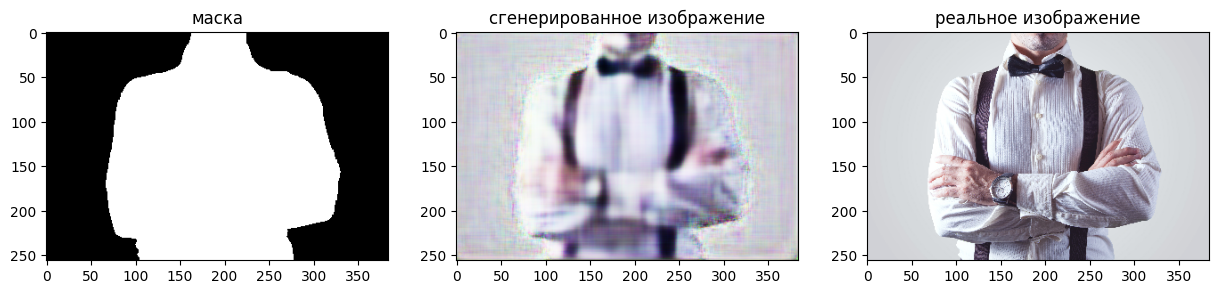

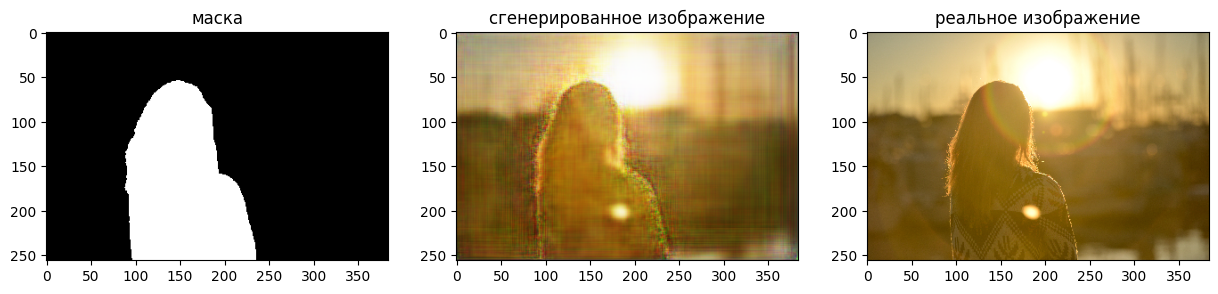

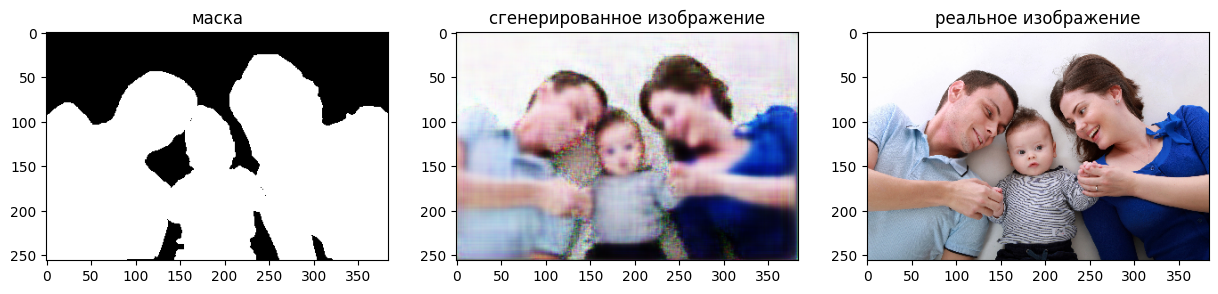

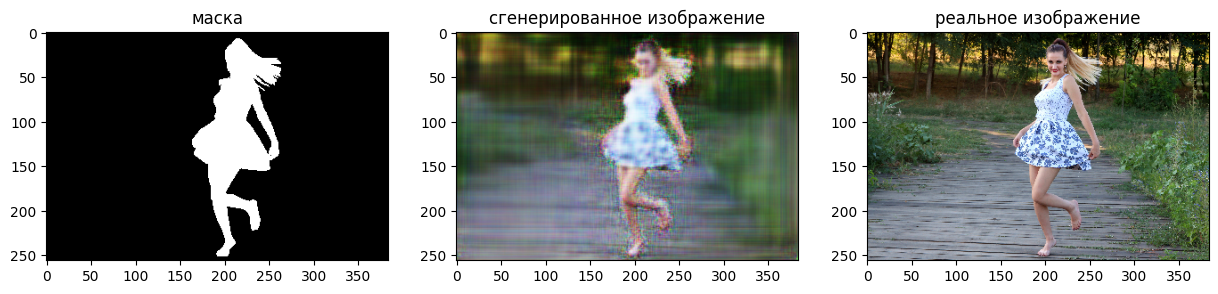

In [30]:
for i in [0,5,7,9]:
   sample_image(gen, images, masks, i)

In [31]:
A = np.matrix(np.random.randint(-5,5,(5,10)))
X = np.matrix(np.random.randint(5,10,(5,10)))
C = np.matrix(np.random.randint(10,15,(5,18)))
AX = np.dot(A, X.T)
Y = AX.dot(C)
Y.shape

(5, 18)

In [32]:
Y=A@X.T@C
Y.shape

(5, 18)